In [1]:
import time
ini=time.time()
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
def un_dumm_sub(pred_dumm):
    pred=pd.concat([pred_dumm.select_dtypes(exclude='bool'),pd.from_dummies(pred_dumm.select_dtypes(include='bool'),sep='~')],axis=1)
    pred=pred[pred.columns[~pred.columns.str.contains('~')]]
    return pred

pred_c=un_dumm_sub(pd.read_csv('~/git/BD/temp/pred_c.csv'))

pred_r=un_dumm_sub(pd.read_csv('~/git/BD/temp/pred_r.csv'))

pred=pred_c.merge(pred_r,how='outer')

pred.date=pred.date.astype('datetime64[ns]')

pred['CO_ANO']=pred.date.dt.year

In [3]:
pred_l=pd.concat([
    pred.drop(columns='KG_LIQUIDO_pred').assign(tipo='real'),
                 pred.drop(columns='KG_LIQUIDO').rename(columns={'KG_LIQUIDO_pred':'KG_LIQUIDO'}).assign(tipo='pred')
                 ]).sort_values('date')

In [4]:
pred_l.CO_MES=pred_l.CO_MES.astype(int)
pred_l.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424 entries, 0 to 211
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   oc          424 non-null    int64         
 1   oc_pred     424 non-null    int64         
 2   date        424 non-null    datetime64[ns]
 3   md_c        424 non-null    int64         
 4   l_min_y     424 non-null    int64         
 5   indv        424 non-null    int64         
 6   l_max_y     424 non-null    int64         
 7   ad_col      424 non-null    int64         
 8   CO_MES      424 non-null    int64         
 9   nick        424 non-null    object        
 10  KG_LIQUIDO  410 non-null    float64       
 11  md_r        410 non-null    float64       
 12  CO_ANO      424 non-null    int32         
 13  tipo        424 non-null    object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(8), object(2)
memory usage: 48.0+ KB


In [5]:
scores=pd.read_csv('~/git/BD/temp/score.csv')
scores.head(1)

r2_max=scores.groupby(by=['CO_MES','nick']).r2.max().reset_index()
r2_max

,CO_MES,nick,r2
0,7,MAP_k,-0.054383
1,7,MOP_k,-0.427347
2,7,SAM_k,0.698097
3,7,UREIA_k,-1.137619


In [6]:
hyper_max=scores.merge(r2_max)
hyper_max

,CO_MES,nick,md_c,md_r,accuracy,precision,recall,r2,ad_col,indv
0,7,UREIA_k,1,1.0,1.0,1.0,1.0,-1.137619,1,0
1,7,SAM_k,1,13.0,1.0,1.0,1.0,0.698097,1,0
2,7,MOP_k,1,13.0,1.0,1.0,1.0,-0.427347,1,0
3,7,MAP_k,1,13.0,1.0,1.0,1.0,-0.054383,1,0


In [7]:
pred_l.head(1)

hyper_max.ad_col.unique()

pred_l.ad_col.unique()

pred_l=pred_l.merge(hyper_max[['CO_MES','nick','md_c','md_r']])

In [8]:
i=pd.read_csv('~/git/BD/temp/imp_fert_quanti.csv').sort_values(by=['CO_ANO','CO_MES'])
i=i[i.SG_UF_NCM=='BA']
i=i[i.nick.isin(['UREIA_k','MAP_k','MOP_k','SAM_k'])]
i=i.groupby(by=['CO_ANO','CO_MES','nick'],observed=True)[['KG_LIQUIDO','VL_FOB']].sum()\
.reset_index().sort_values(by=['CO_ANO','CO_MES','nick'])
i['date']=pd.to_datetime(i.CO_ANO.astype(str)+'/'+i.CO_MES.astype(str)+'/1')

In [9]:
i=i[i.date<pred_l.date.min()].assign(tipo='real').assign(ad_col=0).assign(md_r=1).assign(indv=0)

In [10]:
pred_l.CO_MES=pred_l.CO_MES.astype(int)

In [11]:
pred_l=pred_l[
(pred_l.nick=='MOP_k')
]
pred_l=pred_l.dropna()

In [12]:
i=i.merge(pred_l[['CO_MES','nick']].drop_duplicates())

In [13]:
pred_l.CO_ANO=pred_l.CO_ANO.astype(str)

In [14]:
i.CO_ANO=i.CO_ANO.astype(str)

In [15]:
pred_l=pd.concat([i,pred_l])

In [16]:
pred_l[pred_l.CO_ANO.astype(int)==2018]

,CO_ANO,CO_MES,nick,KG_LIQUIDO,VL_FOB,date,tipo,ad_col,md_r,indv,oc,oc_pred,md_c,l_min_y,l_max_y
36,2018,7,MOP_k,9.452809e+07,NaN,2018-07-01,real,1,13.0,0,1.0,1.0,1.0,15.0,15.0
38,2018,7,MOP_k,5.429281e+07,NaN,2018-07-01,pred,1,13.0,0,1.0,1.0,1.0,15.0,15.0


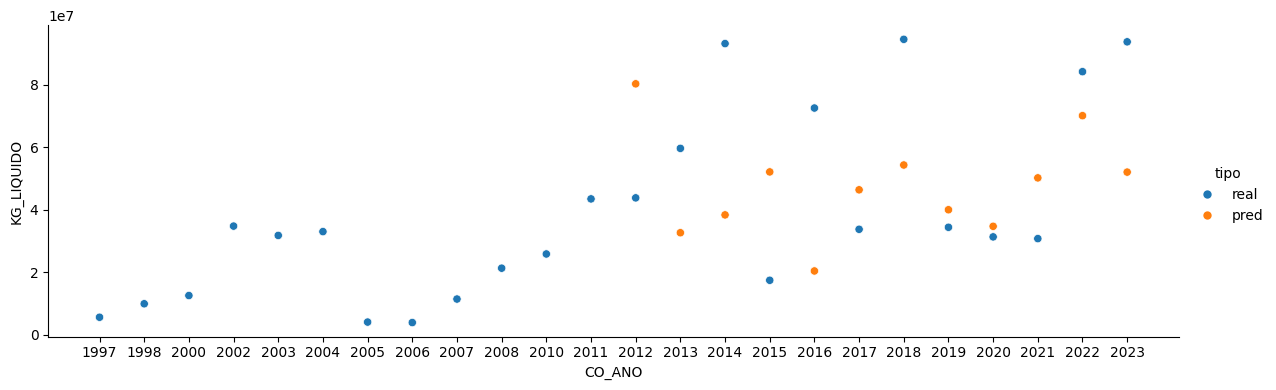

In [17]:
sns.relplot(data=pred_l,x='CO_ANO',y='KG_LIQUIDO',hue='tipo',height=4,aspect=3)

In [18]:
w=pd.concat([i,pred_l])
w[(w.CO_ANO.astype(int)==2014)&(w.tipo=='pred')]

,CO_ANO,CO_MES,nick,KG_LIQUIDO,VL_FOB,date,tipo,ad_col,md_r,indv,oc,oc_pred,md_c,l_min_y,l_max_y
11,2014,7,MOP_k,3.832044e+07,NaN,2014-07-01,pred,1,13.0,0,1.0,1.0,1.0,15.0,15.0
